In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!ls ../data/

embeddings img        modified   raw        vectors


In [3]:
datapath='../data/raw/'
datastorepath='../data/modified/'

In [4]:
import string
import numpy as np
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import json
import ast
import lxml.html
from  more_itertools import unique_everseen
from tqdm import tqdm
from collections import Counter
import operator
import re
import nltk
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

%matplotlib inline
import matplotlib.pyplot as plt

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
# pd.reset_option('display.max_colwidth')

In [5]:
%%time
df1=pd.read_csv(datapath+'products_database_5_Apr.csv',header=None)
df1.columns=['Product ID', 'Name', 'Price', 'Currency', 'Retailer ID',
            'Retailer Name', 'Brand ID', 'Brand Name', 'Description', 'image_small',
            'image_XLarge', 'image_Medium', 'image_Large', 'image_IPhoneSmall',
            'image_Best', 'image_Original', 'image_IPhone', 'Extract Date',
            'Last Modified', 'Colors', 'Sizes', 'Categories']

df2=pd.read_csv(datapath+'products_database_UPTO_2369.csv',header=None)
df2.columns=['Product ID', 'Name', 'Price', 'Currency', 'Retailer ID',
             'Retailer Name', 'Brand ID', 'Brand Name', 'Description', 'image_small',
             'image_XLarge', 'image_Medium', 'image_Large', 'image_IPhoneSmall',
             'image_Best', 'image_Original', 'image_IPhone', 'Extract Date',
             'Last Modified', 'Colors', 'Sizes', 'Categories']

CPU times: user 59.1 s, sys: 13.7 s, total: 1min 12s
Wall time: 1min 23s


In [6]:
%%time
df=df2.append(df1)
df.drop_duplicates(keep=False, inplace=True)

CPU times: user 30.9 s, sys: 29.3 s, total: 1min
Wall time: 1min 8s


In [7]:
df.columns

Index(['Product ID', 'Name', 'Price', 'Currency', 'Retailer ID',
       'Retailer Name', 'Brand ID', 'Brand Name', 'Description', 'image_small',
       'image_XLarge', 'image_Medium', 'image_Large', 'image_IPhoneSmall',
       'image_Best', 'image_Original', 'image_IPhone', 'Extract Date',
       'Last Modified', 'Colors', 'Sizes', 'Categories'],
      dtype='object')

In [23]:
shopstyle_addr=df.loc[:,['Product ID', 'image_Best']]

In [27]:
shopstyle_addr.to_csv(datapath+'shopstyle_addr.csv',index=False)

In [8]:
df=df.iloc[:,[0,1,6,7,8,14,19,21]]
df['From']='shopstyle'

decode

In [9]:
%%time
df['Categories']=df['Categories'].apply(lambda x: ast.literal_eval(x))
df['Colors']=df['Colors'].apply(lambda x: ast.literal_eval(x))
df['Name']=df['Name'].apply(lambda x: ast.literal_eval(x).decode("utf-8"))
df['Brand Name']=df['Brand Name'].apply(lambda x: ast.literal_eval(x).decode("utf-8"))
df['Description']=df['Description'].apply(lambda x: ast.literal_eval(x).decode("utf-8"))

CPU times: user 1min 35s, sys: 3.39 s, total: 1min 39s
Wall time: 1min 40s


remove non-cloth products

In [10]:
# how many categories appear
my_categories = df.Categories.tolist()
category_counter = Counter()
flat = [w for sublist in my_categories for w in sublist]
category_counter.update(flat)
#category_counter
sorted_category_counter = sorted(category_counter.items(), key=operator.itemgetter(1)) # 1 sort on value; 0 sort on keys
#sorted_category_counter

In [11]:
non_cloth_term =  set(open(datapath+'non_cloth_term.txt').read().split('\n'))
df=df[df.Categories.apply(lambda x: sum(1 if w in non_cloth_term else 0 for w in x))==0]
df.reset_index(inplace=True, drop=True)

In [12]:
df.shape

(955818, 9)

modify description

In [13]:
%%time
# join product names, colors, and categories to descriptions
df['Colors'] = df['Colors'].apply(lambda row: ''.join(row)) 
df['Categories'] = df['Categories'].apply(lambda row: ''.join(row))
df['comb_desc'] = df[['Name', 'Description', 'Colors', 'Categories']].apply(lambda row: ' '.join(row), axis=1)

CPU times: user 22.7 s, sys: 601 ms, total: 23.3 s
Wall time: 23.6 s


In [14]:
%%time
# remove brand names in combined descriptions
df['comb_desc'] = df.apply(lambda row: row['comb_desc'].replace(row['Brand Name'], ''), axis=1)
df['comb_desc'] = df['comb_desc'].str.lower()

CPU times: user 27.1 s, sys: 157 ms, total: 27.2 s
Wall time: 27.3 s


remove html formats, digits, punctuations and multiple spaces

In [15]:
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [16]:
%%time
count = df['comb_desc'].apply(lambda x: lxml.html.fromstring(x).find('.//*') is not None)
df.loc[count==True,'comb_desc']=df[count==True]['comb_desc'].apply(lambda html: remove_html_tags(html))

CPU times: user 40.8 s, sys: 85.9 ms, total: 40.9 s
Wall time: 41 s


In [17]:
%%time
df['comb_desc']=df['comb_desc'].str.replace('\d+', ' ')
df['comb_desc']=df['comb_desc'].str.replace('[^\w\s]','')
df['comb_desc']=df['comb_desc'].apply(lambda row: re.sub( '\s+', ' ', row).strip())

CPU times: user 36.4 s, sys: 72.9 ms, total: 36.5 s
Wall time: 36.6 s


plot words length

Text(0.5,1,'combined descriptions words length')

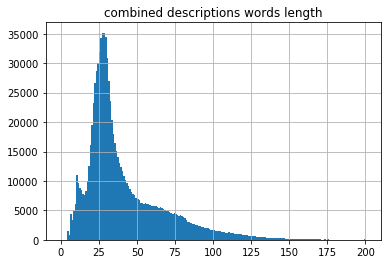

In [18]:
df['comb_desc'].apply(lambda x: len(x.split(' '))).hist(bins=200, range=[0,200])
plt.title('combined descriptions words length')

label styles

In [19]:
df['Brand Name']=df['Brand Name'].str.lower()

In [20]:
classic_brands=['Chloe', 'Michael Kors', 'Burberry', 'Carolina Herrera', 'Coach', 'Jimmy Choo', 'Gucci', 'Stewart Weitzman', 'Vince']
df.loc[df['Brand Name'].isin([x.lower() for x in classic_brands]),'style']='classic'
df[df['Brand Name'].isin([x.lower() for x in classic_brands])]['Brand Name'].value_counts()

michael kors        2451
burberry            1763
gucci               1378
carolina herrera    1008
coach                177
Name: Brand Name, dtype: int64

In [21]:
active_brands=['Lacoste', 'Y-3', 'LuLu Lemon', 'Lucy', 'Toms', 'Alexander Wang', 'Adidas', 'Nike', 'Supreme']
df.loc[df['Brand Name'].isin([x.lower() for x in active_brands]),'style']='active'
df[df['Brand Name'].isin([x.lower() for x in active_brands])]['Brand Name'].value_counts()

alexander wang    3531
adidas            1720
y-3               1023
lacoste            913
nike               309
lucy               296
Name: Brand Name, dtype: int64

In [22]:
bohemian_brands=['Haute Hippie', 'Rachel Zoe',  'Diane Von Furstenburg', 'Anthropologie', 'Free People', 'Isabel Marant', 'LF USA']
df.loc[df['Brand Name'].isin([x.lower() for x in bohemian_brands]),'style']='bohemian'
df[df['Brand Name'].isin([x.lower() for x in bohemian_brands])]['Brand Name'].value_counts()

free people      3989
isabel marant    3147
rachel zoe       1545
haute hippie     1538
Name: Brand Name, dtype: int64

In [23]:
edgy_brands=['Rick Owens', 'Skingraft', 'Alexander McQueen', 'Jonathan Varvatos', 'Rag and Bone', 'All Saints', 
             'Nasty Gal',  'Victor and Rolf', 'Raf Simmons', 'River Island']
df.loc[df['Brand Name'].isin([x.lower() for x in edgy_brands]),'style']='edgy'
df.loc[df['Brand Name'].isin([x.lower() for x in edgy_brands])]['Brand Name'].value_counts()

rick owens           3715
nasty gal            2712
alexander mcqueen    2369
river island         1310
Name: Brand Name, dtype: int64

In [24]:
hipster_brands=['American Apparel', 'Vans','Band of Outsiders', 'APC', 'Acne','Thrift Stores', 'Keds', 'Urban Outfitters']
df.loc[df['Brand Name'].isin([x.lower() for x in hipster_brands]),'style']='hipster'
df.loc[df['Brand Name'].isin([x.lower() for x in hipster_brands])]['Brand Name'].value_counts()

band of outsiders    307
keds                   2
Name: Brand Name, dtype: int64

In [25]:
glam_brands=['Arden B.', 'Minolo Blanik', 'Betsy Johnson', 'Juicy Couture', 'Bebe', 'BCBG', 'Versace']
df.loc[df['Brand Name'].isin([x.lower() for x in glam_brands]),'style']='glam'
df.loc[df['Brand Name'].isin([x.lower() for x in glam_brands])]['Brand Name'].value_counts()

juicy couture    1156
Name: Brand Name, dtype: int64

In [26]:
gothic_brands=['Nicolas Ghesquiere', 'Alexander McQueen', 'Marko Mitanovski', 'Attitude', 'Rick Owens', 'Hot Topic']
df.loc[df['Brand Name'].isin([x.lower() for x in gothic_brands]),'style']='gothic'
df.loc[df['Brand Name'].isin([x.lower() for x in gothic_brands])]['Brand Name'].value_counts()

rick owens           3715
alexander mcqueen    2369
Name: Brand Name, dtype: int64

In [27]:
minimalistic_brands=['Celine', 'Jil Sander', 'Margiela', 'Calvin Klein', 'DKNY', 'Halston Heritage', 'The Row', 'Ayr']
df.loc[df['Brand Name'].isin([x.lower() for x in minimalistic_brands]),'style']='minimalistic'
df.loc[df['Brand Name'].isin([x.lower() for x in minimalistic_brands])]['Brand Name'].value_counts()

calvin klein    3100
the row         2342
jil sander      1954
dkny            1641
celine          1079
Name: Brand Name, dtype: int64

In [28]:
preppy_brands=['Brooks Brothers', 'J. Crew', 'Abercrombie', 'Kate Spade', 'Tommy Hilfiger' , 'Abercrombie and fitch', 'L.L. Bean', 'Madewell',
               'Ralph Lauren']
df.loc[df['Brand Name'].isin([x.lower() for x in preppy_brands]),'style']='preppy'
df.loc[df['Brand Name'].isin([x.lower() for x in preppy_brands])]['Brand Name'].value_counts()

brooks brothers    2558
tommy hilfiger     2156
l.l. bean           988
kate spade          905
madewell            676
ralph lauren         46
Name: Brand Name, dtype: int64

In [29]:
punk_brands=['Viviane Westwood', 'Ann Demeulemeester', 'Converse', 'M.A. Julius', 'United Bamboo', 'Jean Paul Gaultier']
df.loc[df['Brand Name'].isin([x.lower() for x in punk_brands]),'style']='punk'
df.loc[df['Brand Name'].isin([x.lower() for x in punk_brands])]['Brand Name'].value_counts()

ann demeulemeester    1148
jean paul gaultier     391
converse               196
united bamboo           21
Name: Brand Name, dtype: int64

In [30]:
sartorial_brands=['Proenza Schouler', 'Rosie Assoulin', 'Timo Weiland', 'Zimmermann', 'ASOS', 'Moschino', 'Comme Des Garcon']
df.loc[df['Brand Name'].isin([x.lower() for x in sartorial_brands]),'style']='sartorial'
df.loc[df['Brand Name'].isin([x.lower() for x in sartorial_brands])]['Brand Name'].value_counts()

asos                3690
moschino            3616
proenza schouler    3068
zimmermann          1662
rosie assoulin       430
timo weiland         333
Name: Brand Name, dtype: int64

In [31]:
tailored_brands=['Haider Ackerman', 'Victoria Beckham', 'Net-a-porte', 'TopShop', 'ASOS']
df.loc[df['Brand Name'].isin([x.lower() for x in tailored_brands]),'style']='tailored'
df.loc[df['Brand Name'].isin([x.lower() for x in tailored_brands])]['Brand Name'].value_counts()

asos                3690
topshop             2416
victoria beckham    1447
Name: Brand Name, dtype: int64

In [32]:
romantic_brands=['Oscar de la Renta', 'Valentino', 'BCBG', 'Alice and Oliva', 'Pinky Otto', 'Marchesa']
df.loc[df['Brand Name'].isin([x.lower() for x in romantic_brands]),'style']='romantic'
df.loc[df['Brand Name'].isin([x.lower() for x in romantic_brands])]['Brand Name'].value_counts()

oscar de la renta    2796
marchesa             1040
Name: Brand Name, dtype: int64

In [33]:
vintage_brands=['Rachel Zoe', 'Mod Cloth', 'Second Time Around', 'Collette', 'Fish for the Hip']
df.loc[df['Brand Name'].isin([x.lower() for x in vintage_brands]),'style']='vintage'
df.loc[df['Brand Name'].isin([x.lower() for x in vintage_brands])]['Brand Name'].value_counts()

rachel zoe    1545
Name: Brand Name, dtype: int64

In [34]:
western_brands=['Levis', 'Frye', 'Cavenders', 'Wrangler', 'American Eagle', 'Buckle']
df.loc[df['Brand Name'].isin([x.lower() for x in western_brands]),'style']='western'
df.loc[df['Brand Name'].isin([x.lower() for x in western_brands])]['Brand Name'].value_counts()

wrangler    374
frye          5
Name: Brand Name, dtype: int64

In [55]:
df.sample(5)

,Product ID,Name,Brand ID,Brand Name,Description,image_Best,Colors,Categories,From,comb_desc,style
764542,715000052,Chaser Long Sleeve Back Cutout Knit Top,29692,chaser,"Machine wash 60% cotton, 40% polyester <ul> <l...",https://img.shopstyle-cdn.com/pim/ee/3e/ee3ee6...,clgry,Longsleeve Tops,shopstyle,long sleeve back cutout knit top machine wash ...,NaN
435979,713617248,Agnona jersey T-shirt,6304,agnona,White cotton jersey T-shirt from Agnona featur...,https://img.shopstyle-cdn.com/pim/79/3a/793ac8...,White,Tees,shopstyle,jersey tshirt white cotton jersey tshirt from ...,NaN
385054,642839831,Sanctuary Anabella Top,3860,sanctuary,The Anabella Top is a boho-inspired top featur...,https://img.shopstyle-cdn.com/pim/46/70/4670e7...,Blue,Tops,shopstyle,anabella top the anabella top is a bohoinspire...,NaN
903846,714806963,Arc'Teryx Veilance ARC'TERYX VEILANCE MEN'S TE...,32941,arcteryx veilance,Arc'Teryx Veilance's slim pants are cut from b...,https://img.shopstyle-cdn.com/pim/14/3c/143c04...,BLACK,Pants,shopstyle,arcteryx veilance arcteryx veilance mens techc...,NaN
815703,694457010,IRO.JEANS Gnotta Shredded V-Neck Top,31655,iro . jeans,IRO.JEANS takes distressing one step further w...,https://img.shopstyle-cdn.com/pim/14/cc/14cc80...,Black,Tops,shopstyle,irojeans gnotta shredded vneck top irojeans ta...,NaN


In [56]:
%%time
# cols_to_keep = ['Product ID','Brand ID','Brand Name', 'comb_desc']
df.to_hdf(datastorepath+'shopstyle.h5','table')
# df=pd.read_hdf(datastorepath+'shopstyle.h5', 'table')

CPU times: user 5.39 s, sys: 3.35 s, total: 8.74 s
Wall time: 10.2 s


*****

### Farfetch

read data

In [36]:
with open(datapath+'ffetch_13.json', 'r') as f:
    data = (line.strip() for line in f)
    data_json = "[{0}]".format(','.join(data))
    df_ff = pd.read_json(data_json)

In [37]:
# brands_ff=df_ff.loc[0].designer_brands
df_ff.drop(index=0, inplace=True)
df_ff.reset_index(inplace=True, drop=True)

In [38]:
_id=df_ff['_id'].apply(lambda x: x.get('$oid'))
df_ff['product_id']=_id
df_ff.drop(columns=['_id', 'date','designer_brands', 'designer_style_id','discount', 'product_stock_volume', 
                   'product_availability',], inplace=True)

In [39]:
cols=['designer_name','designer_original_name', 'product_colour', 'product_description','product_name', 'product_type']
df_ff.loc[:,cols]=df_ff[cols].applymap(lambda x: ''.join(x))

keep only clothes

In [40]:
category_cloths=['Clothing', 'Vintage & Archive', 'Activewear', 'Jackets','Tops', 'Knitwear', 'Dresses', 'Coats', 'Trousers', 'Skirts']
df_ff=df_ff[df_ff['product_category'].isin(category_cloths)]

In [41]:
category_vintages=['dress', 'jacket', 'skirt', 'coat', 'trousers','shirt', 'blazer', 'top',
                    'suit', 'blouse', 'jumper', 'cardigan', 'sweater', 'T-shirt', 'shorts',
                    'waistcoat', 'jeans', 'jumpsuit', 'raincoat', 'leggings', 'culottes', 'peacoat',
                    't-shirt', 'tunic', 'trouser', 'sweatshirt', 'Jacket', 'dres', 'trenchcoat',
                    'cardi-coat', 'playsuit', 'Coat', 'hoodie', 'pants', 'bodysuit', 'bomber', 
                    'cardigian', 'overcoat', 'midi-skirt', 'Dress', 'SUIT', 'straight', 'tops', 'jakcet', 
                    'parka', 'JACKET', 'romper', 'JACKETS', 'tailcoat', 'COAT', 'T-shirt',
                    'wrapdress', 'Suit', 'DRESSES']
test=df_ff[df_ff['product_category']=='Vintage & Archive']['product_name'].apply(lambda x: x.split(' ')[-1])
a=set(test.index)
b=set(test[test.isin(category_vintages)==True].index)
idx=sorted(list(a-b))
df_ff=df_ff[~df_ff.index.isin(idx)]
df_ff.reset_index(inplace=True, drop=True)

In [42]:
category_vin_noncloth=['swimsuit', 'bra', 'briefs', 'socks', 'bikini', 'thong', 'bralette', 'corset', 'tie', 'cuffs', 'maillot', 'knickers', 'towel', 'babydoll',
                       'ties', 'suspenders', 'panties', 'leotard', 'thongs', 'bralet', 'swuimsuit', 'brooch', 'slippers', ]
test=df_ff['product_name'].apply(lambda x: x.lower())
df_ff=df_ff[~test.str.contains('|'.join(category_vin_noncloth))]
df_ff.reset_index(inplace=True, drop=True)

In [43]:
category_noncloth=['swimwear', 'bikini', 'socks']
df_ff=df_ff[df_ff['product_description'].str.contains('|'.join(category_noncloth))==False]
df_ff.reset_index(inplace=True, drop=True)
test=df_ff['product_description'].str.lower()
test=test.str.replace('\d+', ' ')

clean descriptions

In [44]:
replace_sents = set(open(datapath+'/replace_sents.txt').read().split('\n'))
for sent in tqdm(replace_sents):
    test=test.str.replace(sent, '')
test=test.str.replace('[^\w\s]','')
test=test.apply(lambda row: re.sub('\s+', ' ', row).strip())

100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


In [45]:
df_ff.shape

(106705, 11)

In [46]:
df_ff = df_ff.loc[:,['product_id', 'designer_name', 'designer_original_name', 'product_name', 'product_category', 'product_type', 'product_colour', 'product_description']]
df_ff['comb_desc'] = df_ff[['product_name', 'product_description', 'product_colour', 'product_category', 'product_type']].apply(lambda row: ' '.join(row), axis=1)
df_ff['comb_desc']=df_ff['comb_desc'].str.lower()
df_ff['comb_desc']=df_ff['comb_desc'].apply(lambda row: re.sub('\s+', ' ', row.replace('[^\w\s]','').replace("&", "")).strip())

Text(0.5,1,'descriptions words length')

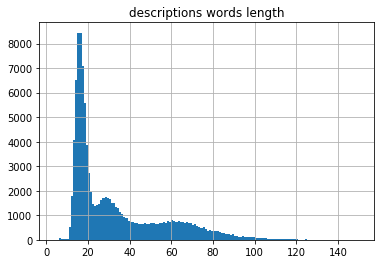

In [47]:
df_ff['comb_desc'].apply(lambda x: len(x.split(' '))).hist(bins=146, range=[4, 150])
plt.title('descriptions words length')

In [48]:
df_ff['From']='farfetch'

In [8]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /Users/yiru/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [133]:
test=df_ff['comb_desc']
test=test.str.replace('\d+','')
test=test.str.replace('/',' ')
test=test.str.replace('-','')
test=test.str.replace('_','')
test=test.apply(lambda row: ' '.join(w for w in nltk.wordpunct_tokenize(row) if w in words or not w.isalpha()))
test=test.str.replace(',','')
test=test.str.replace('[^\w\s]','')
test=test.apply(lambda row: re.sub('\s+', ' ', row).strip())
df_ff['comb_desc']=test

In [140]:
test=df_ff['designer_original_name'].str.lower()
test[test.str.contains('vintage')==True]=test[test.str.contains('vintage')==True].str.replace('vintage', '')
test=test.apply(lambda row: row.rstrip())
df_ff['designer_original_name']=test

label style

In [141]:
# pd.set_option('display.expand_frame_repr', False)
style=pd.read_csv(datapath+'styles.csv')
style['Style Name']=style['Style Name'].str.lower()
style['Brand']=style['Brand'].str.lower()
style.T

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Style Name,athleisure,athleisure,athleisure,athleisure,athleisure,athleisure,bohemian,bohemian,bohemian,bohemian,...,preppy,preppy,preppy,glam,gothic,gothic,gothic,gothic,punk,punk
Brand,adidas,ivy park,puma,lululemon,champion,nike,raquel allegra,isabel marant,free people,anthropologie,...,tommy hilfiger,j crew,ralph lauren,versace,rick owens,damir doma,alexander mcqueen,all saints,vivienne westwood,jean paul gaultier


In [142]:
style_dict=dict(zip(list(style['Brand']), list(style['Style Name'])))

In [143]:
df_ff['style']=df_ff['designer_original_name'].apply(lambda row: style_dict.get(row))

In [144]:
df_ff['style'][df_ff['style'].notnull()==True].value_counts()

gothic          1428
minimalistic    1285
classic          979
romantic         891
bohemian         868
edgy             673
glam             555
punk             404
athleisure       263
preppy           163
Name: style, dtype: int64

In [145]:
df_ff.sample(5)

,product_id,designer_name,designer_original_name,product_name,product_category,product_type,product_colour,product_description,comb_desc,From,style
49248,5af827a74500d65f249ed6eb,kimoraleesimmons,kimora lee simmons,Alana jumpsuit,Clothing,Women,"BLACK, Black/White",Black and white silk blend Alana jumpsuit from...,black and white silk blend from lee black blac...,farfetch,None
83340,5af83e584500d65f249f6b9f,balmain,balmain,high-waisted wrap skirt,Clothing,Women,"BLUE, C3160",Balmain serves up its signature nautical style...,wrap skirt up its signature nautical style wit...,farfetch,None
37214,5af81eb34500d65f249e9c5a,carolineconstas,caroline constas,checked off shoulder blouse,Clothing,Women,"BLUE, PERIWINKLE",Blue checked off shoulder blouse from Caroline...,checked off shoulder blouse blue checked off s...,farfetch,None
25916,5af816b34500d65f249e678e,forteforte,forte forte,long-sleeved shirt,Clothing,Women,"WHITE, AVORIO",White cotton long-sleeved shirt from Forte For...,shirt white cotton shirt from forte forte a cl...,farfetch,None
83585,5af83e8d4500d65f249f6caa,stellamccartney,stella mccartney,knitted tank top,Clothing,Women,"WHITE, 9000",Stella McCartney has developed a reputation of...,knitted tank top stella a reputation of distin...,farfetch,None


store data

In [146]:
%%time
# cols_to_keep = ['Product ID','Brand ID','Brand Name', 'comb_desc']
df_ff.to_hdf(datastorepath+'farfetch.h5','table')
# df_ff=pd.read_hdf(datastorepath+'farfetch.h5', 'table')

CPU times: user 609 ms, sys: 139 ms, total: 748 ms
Wall time: 857 ms


*****

### NAP

In [147]:
with open(datapath+'/nap.json', 'r') as f:
    data = (line.strip() for line in f)
    data_json = "[{0}]".format(','.join(data))
    df_nap = pd.read_json(data_json)

In [148]:
# brands_nap=df_nap.loc[0].designer_brands
df_nap.drop(index=0, inplace=True)
df_nap.reset_index(inplace=True, drop=True)

_id=df_nap['_id'].apply(lambda x: x.get('$oid'))
df_nap['product_id']=_id
df_nap.drop(columns=['_id', 'date','designer_brands', 'product_availability',], inplace=True)

In [149]:
cols=['designer_name','designer_original_name', 'nap_id', 'product_description']
df_nap.loc[:,cols]=df_nap[cols].applymap(lambda x: ''.join(x))

In [150]:
df_nap=df_nap[df_nap['product_category'].str.contains('Clothing')]
df_nap=df_nap[~df_nap['product_category'].str.contains('Beachwear')]
df_nap=df_nap[~df_nap['product_category'].str.contains('Accessories')]
df_nap.reset_index(inplace=True, drop=True)

In [151]:
def rmv_ele(row, index):
    row.pop(index)
    return row
test=df_nap['product_description']
test=test.apply(lambda row: row.replace('][', '- ').replace(".'", '- ').replace("'. '", "- ").replace("', '", "- "))
test=test.str.replace('\d+', ' ')

In [152]:
replace_sents = set(open(datapath+'replace_sents.txt').read().split('\n'))
for sent in tqdm(replace_sents):
    test=test.str.replace(sent, '')

100%|██████████| 78/78 [00:01<00:00, 44.19it/s]


In [153]:
test=test.apply(lambda row: row.split('- '))
test=test.apply(lambda row: row[3:])
test=test.apply(lambda row: rmv_ele(row, 1))
test=test.apply(lambda row: " ".join(row))
test=test.apply(lambda row: re.sub( '\s+', ' ', row ).strip())

In [154]:
test=test.str.lower()
df_nap['product_description']=test

In [155]:
df_nap = df_nap[['product_id', 'designer_name', 'designer_original_name', 'product_name', 'product_category', 'product_description']]
df_nap['comb_desc'] = df_nap[['product_name', 'product_description', 'product_category']].apply(lambda row: ' '.join(row), axis=1)
df_nap['comb_desc']=df_nap['comb_desc'].str.lower().replace('[^\w\s]','')

In [156]:
df_nap['comb_desc']=df_nap['comb_desc'].apply(lambda row: re.sub('\s+', ' ', row.replace('[^\w\s]','').replace("&", "").replace("/", '')).strip())

Text(0.5,1,'descriptions words length')

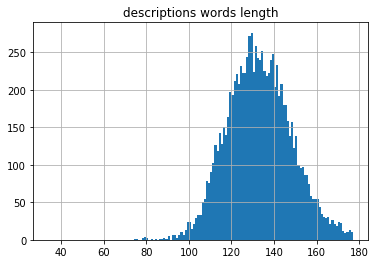

In [157]:
df_nap['comb_desc'].apply(lambda x: len(x.split(' '))).hist(bins=143, range=[34, 177])
plt.title('descriptions words length')

In [158]:
df_nap['From']='nap'

In [253]:
test=df_nap['comb_desc']
test=test.str.replace('\d+','')
test=test.str.replace('/',' ')
test=test.str.replace('-','')
test=test.str.replace('_','')
test=test.str.replace(',','')
test=test.str.replace('[^\w\s]','')
#test=test.apply(lambda row: ' '.join(w for w in nltk.wordpunct_tokenize(row) if w in words or not w.isalpha()))
test=test.apply(lambda row: re.sub('\s+', ' ', row).strip())
df_nap['comb_desc']=test

label style

In [254]:
df_nap['style']=df_nap['designer_original_name'].str.lower().apply(lambda row: style_dict.get(row))

In [255]:
df_nap['style'][df_nap['style'].notnull()==True].value_counts()

romantic        220
gothic          172
minimalistic    139
bohemian        114
classic         98 
edgy            89 
glam            30 
punk            16 
Name: style, dtype: int64

In [161]:
df_nap.sample(5)

,product_id,designer_name,designer_original_name,product_name,product_category,product_description,comb_desc,From,style
8318,5b0140f24500d65c4d2fe113,michaelmichaelkors,MICHAEL Michael Kors,Open-knit cotton-blend sweater,Clothing / Knitwear / Medium Knit,designed for a loose fit dropped shoulder seam...,open-knit cotton-blend sweater designed for a ...,nap,None
8548,5b0140ff4500d65c4d2fe266,jamesperse,James Perse,Genie Supima cotton-terry track pants,Clothing / Pants / Track Pants,"fits true to size, take your normal size cut f...",genie supima cotton-terry track pants fits tru...,nap,None
3689,5b013f834500d65c4d2fbd11,stellamccartney,Stella McCartney,Crystal-embellished mesh and cady gown,Clothing / Dresses / Gowns,"intended to be fitted at the bust and waist, s...",crystal-embellished mesh and cady gown intende...,nap,None
9591,5b0141854500d65c4d2fefd1,madewell,Madewell,Ex-Boyfriend cotton-chambray shirt,Clothing / Tops / Shirts,"designed for a relaxed fit mid-weight, non-str...",ex-boyfriend cotton-chambray shirt designed fo...,nap,None
2452,5b013f484500d65c4d2fb748,calvinklein205w39nyc,CALVIN KLEIN 205W39NYC,Coated cotton-blend canvas trench coat,Clothing / Coats / Trench Coats,"designed for a swing cut, use the belt to cinc...",coated cotton-blend canvas trench coat designe...,nap,None


In [256]:
%%time
# cols_to_keep = ['Product ID','Brand ID','Brand Name', 'comb_desc']
df_nap.to_hdf(datastorepath+'nap.h5','table')
# df_ff=pd.read_hdf('datastorepath+'nap.h5', 'table')

CPU times: user 42.3 ms, sys: 24.7 ms, total: 66.9 ms
Wall time: 78.2 ms


*****

combine dataset

In [261]:
df_ff=df_ff[['product_id', 'designer_original_name', 'product_name', 'comb_desc', 'From', 'style']]
df_nap=df_nap[['product_id', 'designer_original_name', 'product_name', 'comb_desc', 'From', 'style']]
df_ss=df[['Product ID', 'Brand Name', 'Name', 'comb_desc', 'From', 'style']]
df_ss.columns=['product_id', 'designer_original_name', 'product_name', 'comb_desc', 'From', 'style']

In [305]:
df=df_ss.append(df_nap.append(df_ff, ignore_index=True), ignore_index=True)

In [307]:
test=df['comb_desc']
test=test.str.replace('\d+','')
test=test.str.replace('/',' ')
test=test.str.replace('-','')
test=test.str.replace('_','')
#test=test.apply(lambda row: ' '.join(w for w in nltk.wordpunct_tokenize(row) if w in words or not w.isalpha()))
test=test.str.replace(',','')
test=test.str.replace('[^\w\s]','')
test=test.apply(lambda row: re.sub('\s+', ' ', row).strip())
df['comb_desc']=test

In [26]:
#remove non english words
test=df['comb_desc']
test=test.apply(lambda row: ' '.join(w for w in nltk.wordpunct_tokenize(row) if w in words or not w.isalpha()))
df['comb_desc']=test

In [27]:
df.to_hdf(datastorepath+'df.h5','table')
#df=pd.read_hdf(datastorepath+'df.h5','table')